### Prepping DataFrame

Performing a few final steps to prepare the DataFrame for machine learning algorithms.

In [1]:
#Running PY script to read and clean dataframe
%run ../src/read_data.py
%run ../src/clean_data.py
%run ../src/create_features.py

#Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Setting up matplotlib and setting graph styles
%matplotlib inline
sns.set_style('whitegrid')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### PCA

Looking into principal component analysis to reduce the number of dimensions/features that I am working with.

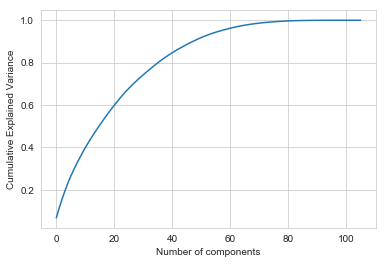

In [2]:
#Apply PCA to the scaled data
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_scaled)
features = range(pca.n_components_)

#Plot the number of components versus the cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('../reports/figures/PCA.png', bbox_inches='tight')
plt.show()

It looks like about 45 features can account for 90% of the explained variance.

In [3]:
pca=PCA(n_components=45)
df_pca = pca.fit_transform(df_scaled)

### Predict severity of event
Try predicting severity of event (predicting the casualty rate of an incident)

In [4]:
from sklearn.model_selection import train_test_split

X = df_pca
y = casualties_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge(fit_intercept=False)
ridge_cv = GridSearchCV(ridge, param_grid, cv=3)
ridge_cv.fit(X,y)

best_alpha = ridge_cv.best_params_['alpha']
print(best_alpha)

100


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [6]:
ridge = Ridge(alpha=best_alpha, fit_intercept = False)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge.score(X_test, y_test)

0.5305377357323552

### Identifying Strong Features

In [7]:
X = df_scaled
y = casualties_scaled

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

lasso = Lasso(fit_intercept=False)

lasso_cv = GridSearchCV(lasso, param_grid, cv=3)

lasso_cv.fit(X,y)

lasso_best_alpha = lasso_cv.best_params_['alpha']

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [8]:
lasso = Lasso(alpha=lasso_best_alpha, fit_intercept=False)
lasso.fit(X, y)
lasso_coef = lasso.coef_

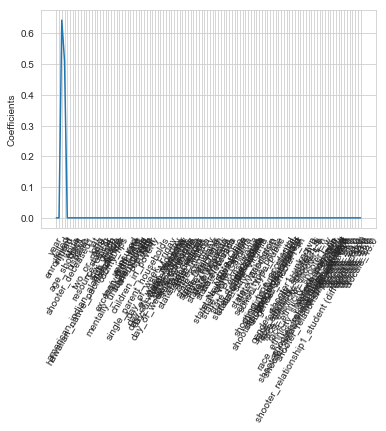

In [9]:
plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns, rotation=60)
plt.ylabel('Coefficients')
plt.show()

In [10]:
df_scaled.loc[:,lasso_coef != 0].columns

Index(['killed', 'injured'], dtype='object')

So...Lasso identifies the strongest predictors of casualties are the variables killed and injured, and that everything else is pretty useless.  That's great!  I'm going to try predicting again without those variables included to see what happens.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


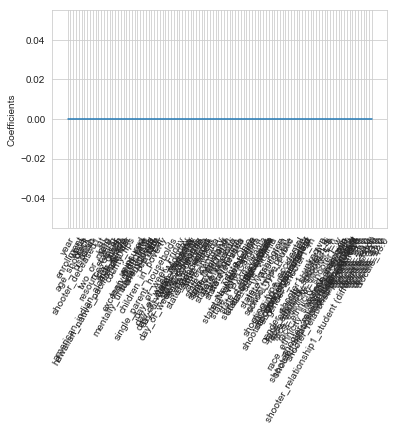

In [11]:
X = df_scaled.drop(['killed', 'injured'], axis=1)
y = casualties_scaled

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso(fit_intercept=False)
lasso_cv = GridSearchCV(lasso, param_grid, cv=3)
lasso_cv.fit(X,y)
lasso_best_alpha = lasso_cv.best_params_['alpha']

lasso = Lasso(alpha=lasso_best_alpha, fit_intercept=False)
lasso.fit(X, y)
lasso_coef = lasso.coef_

plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns, rotation=60)
plt.ylabel('Coefficients')
plt.show()

So it looks like the Lasso regression is telling me that none of the variables available have a strong relationship with the response variable, casualties.  Keeping in mind that the larger casualties happened mostly in the "Indiscriminate" shooting type, I wonder if a better route to go would be to use Logistic Regression to try and predict the probability of the indiscriminate shooting type.

### Unsupervised learning - Clusters

Elbow Method to help determine the potential number of clusters

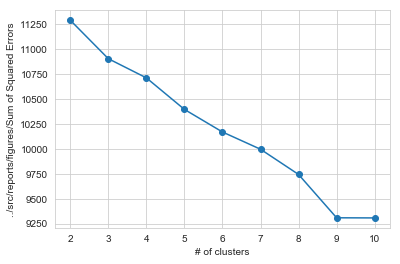

In [13]:
from sklearn.cluster import KMeans

#Initialize empty list and values for the number of clusters
squared_errors = []
K = range (2,11)

#For each value of K, fit a KMeans clustering algorithm, fit to sample data, and calculate squared error
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(df_scaled)
    squared_errors.append(model.inertia_)
    
#Create plot comparing # of clusters to squared error
plt.plot(K, squared_errors, marker="o")
plt.title('')
plt.xlabel('# of clusters')
plt.ylabel('../src/reports/figures/Sum of Squared Errors')
plt.show()

Well, that seems pretty linear.  Not seeing a clear elbow or knee there anywhere.  I tried upping the number of clusters, but this linear pattern continued.

#### Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.028569776310139332
For n_clusters = 3 The average silhouette_score is : 0.023613696740045508
For n_clusters = 4 The average silhouette_score is : 0.04073207372263929
For n_clusters = 5 The average silhouette_score is : 0.024044124791133697
For n_clusters = 6 The average silhouette_score is : 0.017123840458776414
For n_clusters = 7 The average silhouette_score is : 0.010430078151914355
For n_clusters = 8 The average silhouette_score is : 0.014028539279644689
For n_clusters = 9 The average silhouette_score is : -0.014852695349417062
For n_clusters = 10 The average silhouette_score is : 0.011742637916277561


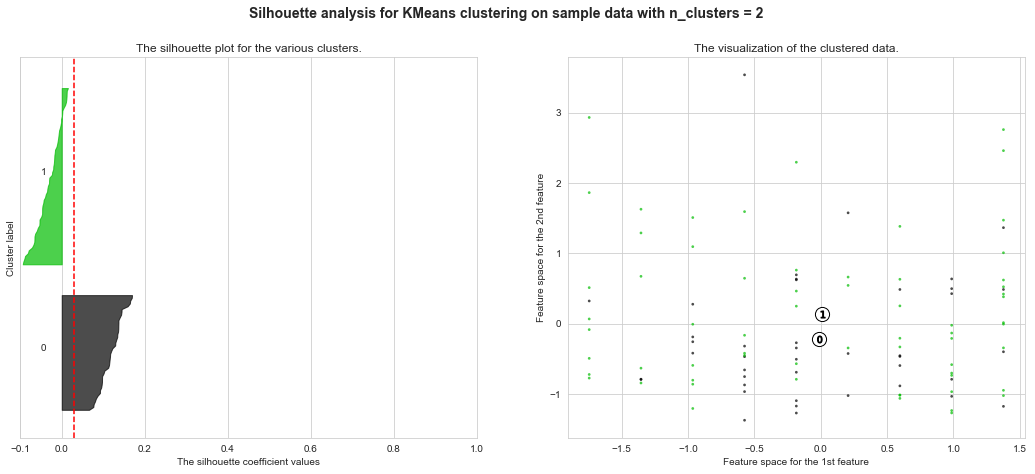

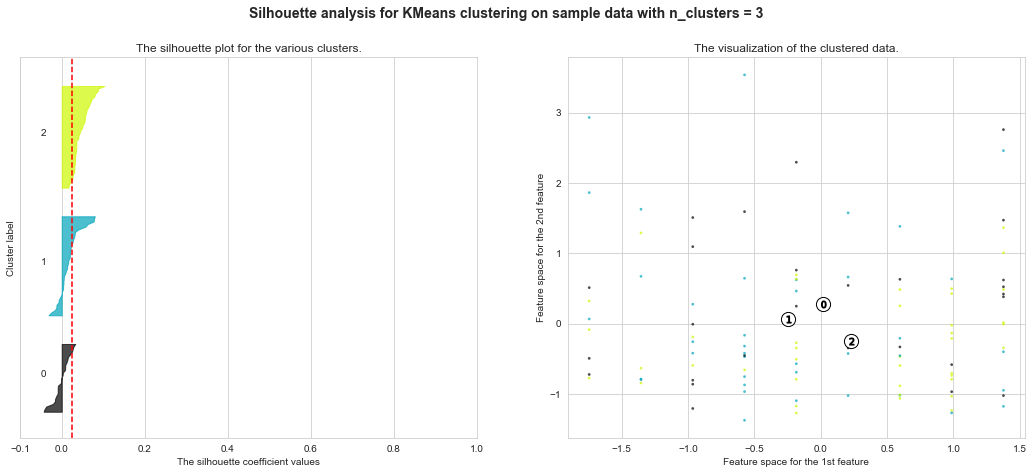

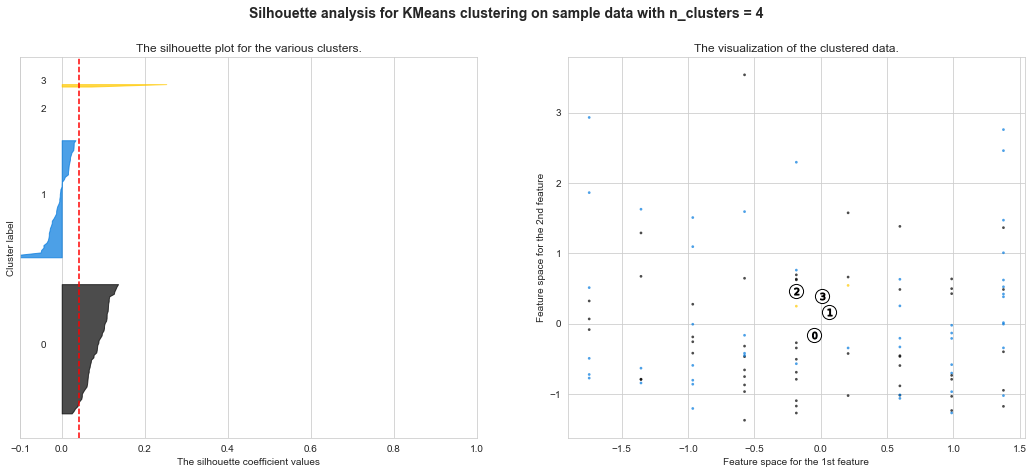

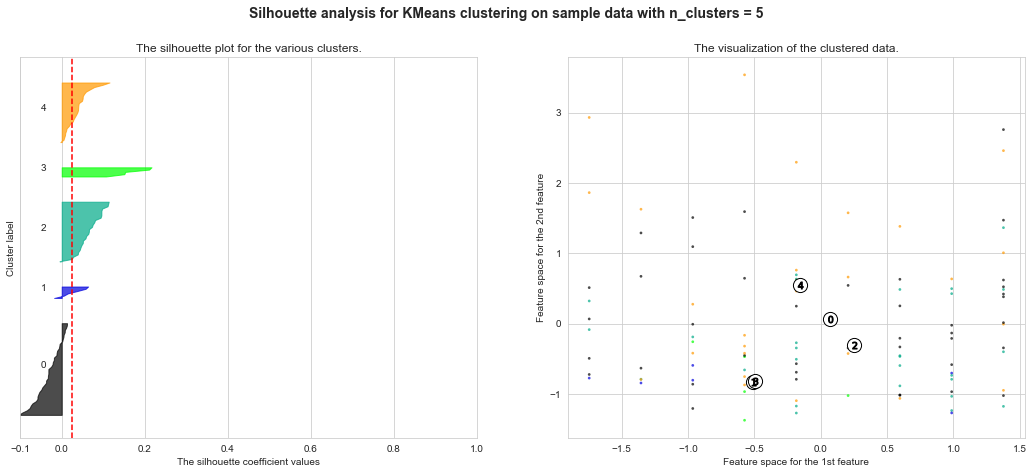

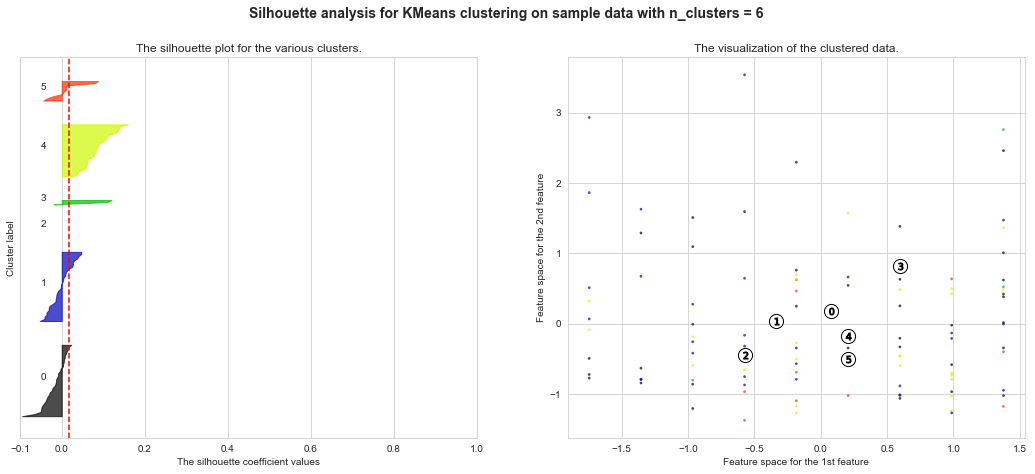

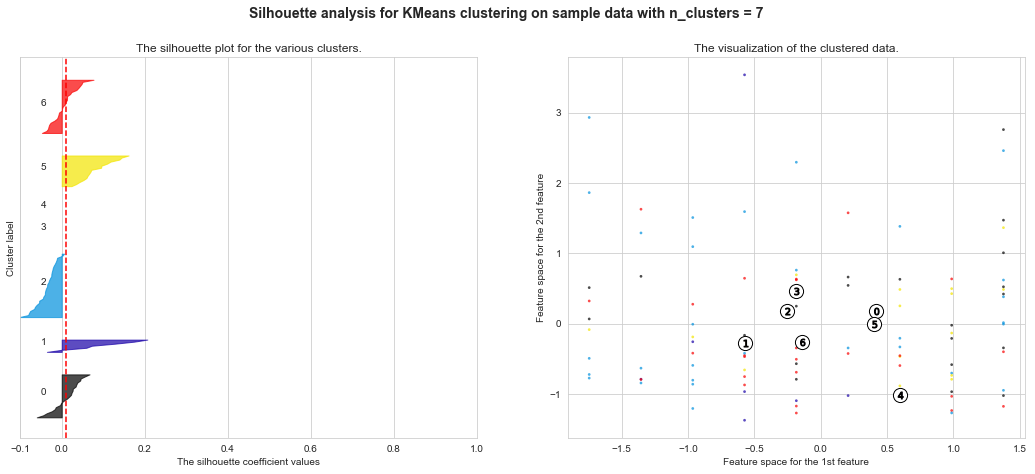

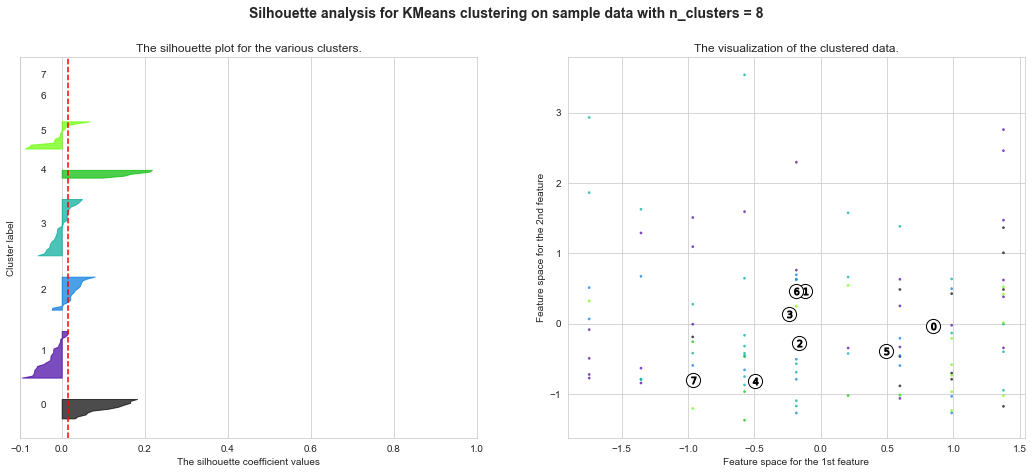

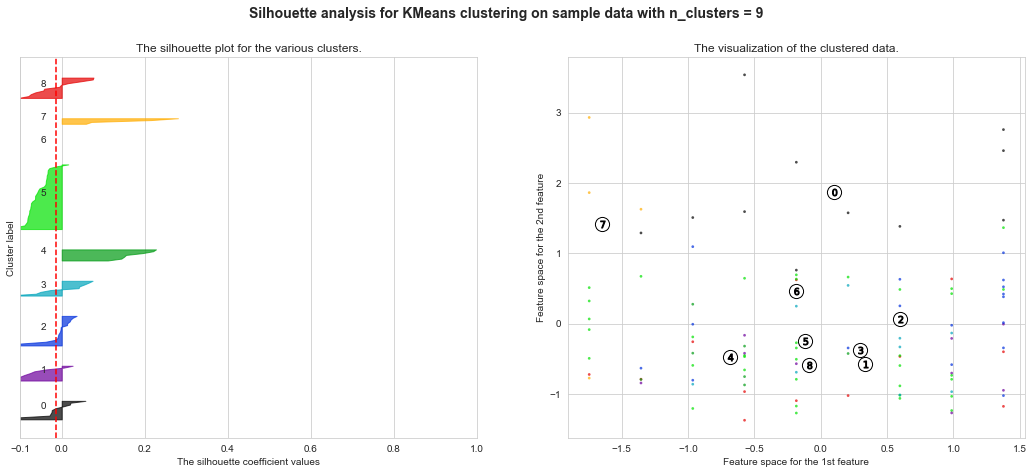

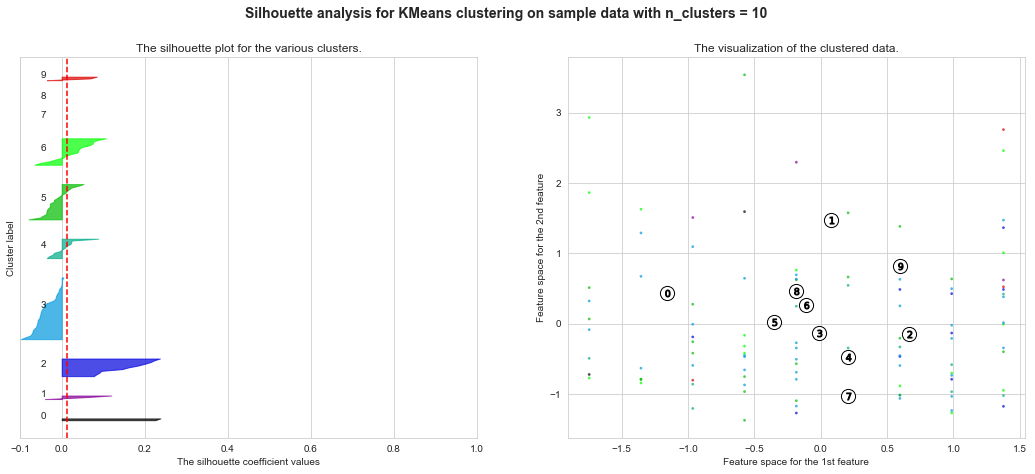

In [14]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
X=scaled

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Investigate relationship between counties and incidents of school violence



In [15]:
#Make FIPS column easier to access
health = health.reset_index()

#Create list of tuples that identify county and year during which an incident of school violence occurred
violence_identifier = list(zip(school['county_fips'], school['year']))

#Create function to identify whether a specific tuple of county and year are in the list of violence identifiers
def identify_violence(row):
    if (row['FIPS'], row['year']) in violence_identifier:
        return 1
    else:
        return 0

#Apply function to health dataframe to create a new column that identifies with a 1 which rows correspond to a year of school violence for a specific county
health['school_violence'] = health.apply(identify_violence, axis=1)

#Drop rows that are missing all county health data
health = health.dropna(how='all', subset = ['mentally_unhealthy_days', 'excessive_drinking', 'teen_birth_rate', 
                                           'uninsured', 'grad_rate', 'some_college', 'unemployed', 'children_in_poverty',
                                           'single_parent_households', 'pcp_rate'])

In [16]:
health.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28316 entries, 0 to 28329
Data columns (total 13 columns):
FIPS                        28316 non-null float64
mentally_unhealthy_days     26316 non-null float64
excessive_drinking          24337 non-null float64
teen_birth_rate             27076 non-null float64
uninsured                   28307 non-null float64
grad_rate                   25706 non-null float64
some_college                28314 non-null float64
unemployed                  28306 non-null float64
children_in_poverty         28306 non-null float64
single_parent_households    28302 non-null float64
pcp_rate                    27333 non-null float64
year                        28316 non-null int64
school_violence             28316 non-null int64
dtypes: float64(11), int64(2)
memory usage: 3.0 MB


Ideas for quickly replacing missing values:
1.  Drop all rows withs missing values?
2.  Simply use the average to replace everything in that column with the mean (fast, likely not very accurate or helpful)
3.  Use a value from the same county in a different year if it exists first, then use the mean if it doesn't exist (possibly harder to code, but likely much more realistic.

Would it make more sense to use the average for that year or the average for that county?  I'm leaning towards the county

THOUGHT!!!!! What if I replace it with the average for that county in particular!  That should be relatively quick and accurate but allow me to ignore looking for the next closest year.  It would probably be better to do an average of the year before and the year after, but then I would have to decide what to do with the edge cases that don't have a year before/after them.

In [17]:
np.sum(health.loc[health.school_violence == 0, :].isna())

FIPS                           0
mentally_unhealthy_days     2000
excessive_drinking          3979
teen_birth_rate             1240
uninsured                      9
grad_rate                   2610
some_college                   2
unemployed                    10
children_in_poverty           10
single_parent_households      14
pcp_rate                     983
year                           0
school_violence                0
dtype: int64

Only missing values for counties that didn't have an incident of school violence.  That seems waaaay too coincidental.  Make sure to ask Aiden about this the next time we talk.  Maybe there is a correlation, or maybe my earlier code did something?  Granted they are a wildly different size, so it could just be luck of the draw

In [18]:
np.sum(np.sum(health.loc[health.school_violence == 0, :].isna()))

10857

In [19]:
np.sum(health.loc[health.school_violence == 1, :].isna())

FIPS                        0
mentally_unhealthy_days     0
excessive_drinking          0
teen_birth_rate             0
uninsured                   0
grad_rate                   0
some_college                0
unemployed                  0
children_in_poverty         0
single_parent_households    0
pcp_rate                    0
year                        0
school_violence             0
dtype: int64

Creating average values per county.  Plan to use this to impute missing values in health df.

In [20]:
county_means = health.groupby('FIPS').mean()

In [21]:
county_means.loc[county_means.isna().sum(axis=1)>0, :].shape

(91, 12)

In [22]:
county_means.shape

(3199, 12)

In [23]:
np.sum(county_means.isnull())

mentally_unhealthy_days      0
excessive_drinking           1
teen_birth_rate             83
uninsured                    1
grad_rate                   18
some_college                 0
unemployed                   1
children_in_poverty          1
single_parent_households     0
pcp_rate                     2
year                         0
school_violence              0
dtype: int64

91 rows have no information from 2010-2018 to create a value for that county.  Biggest issues in teen_birth_rate and grad_rate.  Look at overall distribution of values.  If there is not a lot of variance, may be suitable to use the overall average to replace those values.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


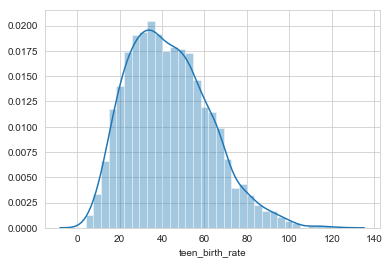

In [24]:
sns.distplot(county_means.teen_birth_rate.dropna())

In [25]:
county_means.teen_birth_rate.describe()

count    3116.000000
mean       43.291810
std        19.159456
min         4.106331
25%        28.649753
50%        41.407225
75%        55.767417
max       123.057213
Name: teen_birth_rate, dtype: float64

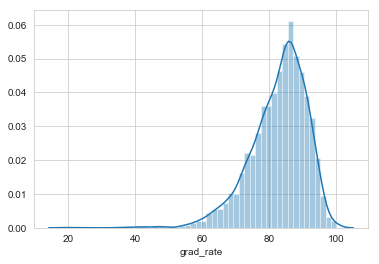

In [26]:
sns.distplot(county_means.grad_rate.dropna())

In [27]:
county_means.grad_rate.describe()

count    3181.000000
mean       82.694670
std         8.403683
min        19.098227
25%        78.012072
50%        84.184874
75%        88.620499
max       100.000000
Name: grad_rate, dtype: float64

Because both shapes are a little skewed in one direction or another, might be better to use the median value instead.

In [28]:
col_means = county_means.median()

for col in county_means.columns:
    county_means[col].fillna(county_means.median()[col], inplace=True)

In [29]:
health = health.merge(county_means, how='left', on='FIPS')
x = health.columns[1:11]
y = health.columns[13:23]
col_names = zip(x, y)

for x,y in col_names:
    health[x].fillna(health[y], inplace=True)

np.sum(health.isnull())

FIPS                          0
mentally_unhealthy_days_x     0
excessive_drinking_x          0
teen_birth_rate_x             0
uninsured_x                   0
grad_rate_x                   0
some_college_x                0
unemployed_x                  0
children_in_poverty_x         0
single_parent_households_x    0
pcp_rate_x                    0
year_x                        0
school_violence_x             0
mentally_unhealthy_days_y     0
excessive_drinking_y          0
teen_birth_rate_y             0
uninsured_y                   0
grad_rate_y                   0
some_college_y                0
unemployed_y                  0
children_in_poverty_y         0
single_parent_households_y    0
pcp_rate_y                    0
year_y                        0
school_violence_y             0
dtype: int64

In [30]:
# Drop county means columns
health.rename(columns={'FIPS':'FIPS_x'}, inplace=True)
health = health.filter(regex='_x')
health.rename(columns = lambda x:str(x)[:-2], inplace=True)

In [31]:
health.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28316 entries, 0 to 28315
Data columns (total 13 columns):
FIPS                        28316 non-null float64
mentally_unhealthy_days     28316 non-null float64
excessive_drinking          28316 non-null float64
teen_birth_rate             28316 non-null float64
uninsured                   28316 non-null float64
grad_rate                   28316 non-null float64
some_college                28316 non-null float64
unemployed                  28316 non-null float64
children_in_poverty         28316 non-null float64
single_parent_households    28316 non-null float64
pcp_rate                    28316 non-null float64
year                        28316 non-null int64
school_violence             28316 non-null int64
dtypes: float64(11), int64(2)
memory usage: 3.0 MB


In [32]:
# X = df_pca
# y = scaler.fit_transform(df.shooting_type_indiscriminate.values.reshape(-1,1))
# X_train, X_test, y_train, y_test = train_test_split(X, y)


# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

In [33]:
#Preprocessing health dataframe for logistic regression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled = scaler.fit_transform(health)
health_scaled = pd.DataFrame(data=scaled, columns=health.columns)

X = health_scaled.drop(['FIPS', 'school_violence', 'year'], axis=1)
y = health['school_violence']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [34]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, '../reports/figures/Logistic Regression ROC Curve')

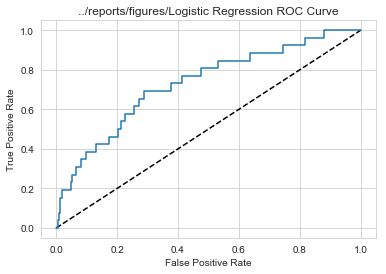

In [53]:
from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('../reports/figures/Logistic Regression ROC Curve')

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_prob)

0.7264557362388073

In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=3, scoring='roc_auc')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.71181564, 0.82055053, 0.70322238])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


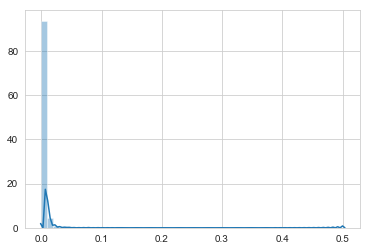

In [39]:
sns.distplot(y_pred_prob)

In [40]:
np.mean(y_pred_prob)

0.004144118049414006

In [41]:
np.max(y_pred)

1

It is predicting all 0's.  Tried stratifying my train and test sets which appears to have worked, but they make up such a small section of the data.  I should focus more on the probabilities, because I think they are all low since there are so few counties with incidents of school violence.

* LAter question: is there a way to alter the cut-off value for logistic regression's predictions?

        There is.  Most methods of adjusting the thresshold are baed on the receiver operating characteristcs and Youden's J statistic.  This would be a good area for further investigation into this project.

In [42]:
np.sum(y_train)/len(y_train)

0.0037199227762866696

In [43]:
np.sum(y_test)/len(y_test)

0.0036728351462070913

In [44]:
count=0
for col in X.columns:
    print('{}: {}'.format(col, round(logreg.coef_[0,count], 4)))
    count += 1

mentally_unhealthy_days: 0.1246
excessive_drinking: 0.0822
teen_birth_rate: -0.1372
uninsured: 0.1266
grad_rate: -0.4092
some_college: 0.6247
unemployed: -0.0871
children_in_poverty: -0.0235
single_parent_households: 0.3368
pcp_rate: 0.2528


In [45]:
#Re-separating health into X and y variables, and investigating rare class imbalance
X = health.drop(['FIPS', 'school_violence', 'year'], axis=1)
y = health['school_violence']
print(np.sum(y)/len(y))
print(X.shape, y.shape)

0.003708150868766775
(28316, 10) (28316,)


In [46]:
#Using smote to oversample the rare class
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_sample(X,y)
print(np.sum(y_res)/len(y_res))
print(X.shape, y.shape)

0.5
(28316, 10) (28316,)


In [47]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X,y,stratify=y)

In [48]:
X_res_train.shape

(21237, 10)

In [49]:
#Preprocessing resamplehealth dataframe for logistic regression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_res_train_scaled = scaler.fit_transform(X_res_train)
X_res_test_scaled = scaler.transform(X_res_test)

In [50]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_res_train_scaled, y_res_train)
y_pred = logreg.predict(X_res_test_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


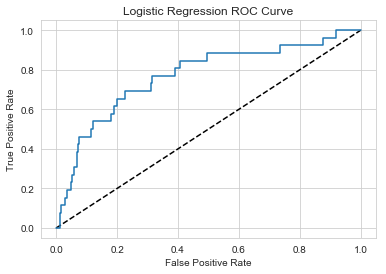

In [54]:
from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_res_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_res_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.savefig('../reports/figures/roc_curve_resampled')

In [55]:

np.max(y_pred_prob)

0.27949462669878844

In [56]:
health.loc[y_pred==1,:]

,FIPS,mentally_unhealthy_days,excessive_drinking,teen_birth_rate,uninsured,grad_rate,some_college,unemployed,children_in_poverty,single_parent_households,pcp_rate,year,school_violence


In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_res_test, y_pred)

0.9963271648537929

In [58]:
sorted(y_pred_prob, reverse=True)

[0.27949462669878844,
 0.06489217302348892,
 0.06315182063046625,
 0.06313863382443975,
 0.06039640054777789,
 0.059681320889510656,
 0.057657363222048334,
 0.056314179425878984,
 0.049452235679906864,
 0.047217151190246574,
 0.0459614992023354,
 0.04227030065971869,
 0.04086412785850044,
 0.03995371040166601,
 0.03864423334274716,
 0.038549718063451976,
 0.03844176076361045,
 0.03826783021307215,
 0.036353129841496225,
 0.035881043056324155,
 0.035816684997721664,
 0.03528043591332179,
 0.035171781040050365,
 0.033692689487483524,
 0.03364215549136794,
 0.03337110801566501,
 0.03144658598888434,
 0.031285231412531166,
 0.029706286266119323,
 0.028803664053657776,
 0.028581033814750318,
 0.02849711720858385,
 0.028394624322137584,
 0.02823536741389484,
 0.028026612798949958,
 0.027074916059783998,
 0.02698937744869886,
 0.02632424021535683,
 0.025935357004508084,
 0.025365959851178076,
 0.024651760884018933,
 0.024191708061038205,
 0.02413330533477637,
 0.023962269743190656,
 0.0237802